# Weight total least squares straight line fit

Converting [Matlab code](https://www.mathworks.com/matlabcentral/fileexchange/17466-weighted-total-least-squares-straight-line-fit) for weighted total least squares straight line fit.

Goal of this work is to find the slope of the line fitting y vs x, where x=A (A$_{min}$ or A$_{max}$) and y=ln(M/H) for M in [M$_{s1}$, M$_{s2}$, M$_{c1}$, M$_{c2}$].

In [75]:
from scipy.optimize import fminbound
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [60]:
# Define functions for later use
def calc_p(alpha, x, y, ux, uy):
    uk2 = ux**2*np.sin(alpha)**2 + uy**2*np.cos(alpha)**2
    u2 = 1/np.mean(1/uk2)
    w = u2/uk2
    xbar = np.mean(w*x)
    ybar = np.mean(w*y)
    p = ybar*np.cos(alpha) - xbar*np.sin(alpha)
    return p, uk2, u2

def chialpha(alpha, x, y, ux, uy):
    p, uk2, u2 = calc_p(alpha, x, y, ux, uy)
    chi = np.sum( (y*np.cos(alpha) - x*np.sin(alpha) - p)**2/uk2)
    return chi

In [309]:
# read in data
df = pd.read_csv('2020-0413-Scavenging Kinetics.csv')
df['Ms1-mean'].iloc[2] = df['Ms1-mean'].iloc[2] + df['Ms1-std'].iloc[2]
df['Mc2-mean'].iloc[0] = df['Mc2-mean'].iloc[0] + df['Mc2-std'].iloc[0]
df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 1,Amin-mean,Amin-std,Amax-mean,Amax-std,H-mean,H-std,Ms1-mean,Ms1-std,Ms2-mean,Ms2-std,Mc1-mean,Mc1-std,Mc2-mean,Mc2-std
0,1,20,2450,0.660,0.23,5.5,2,0.565,0.001,0.56,0.09,0.42,0.08,1.14,0.25,0.11,0.20
1,2,21,2450,1.982,0.70,11.1,3,0.458,0.001,0.11,0.04,0.25,0.04,0.56,0.17,0.36,0.16
2,3,23,2450,6.342,2.23,30.0,5,0.263,0.001,0.02,0.02,0.12,0.02,0.15,0.10,0.18,0.09


In [304]:
# keys to loop over
As = ['Amin', 'Amax']
Ms = ['Ms1', 'Ms2', 'Mc1', 'Mc2']
H = 'H'

## The calculations

The input options of A and M are looped over in the following calculations. The Matlab script (now in Python) is used for each combination.

### Uncertainties

The uncertainties for $x=A$ are given directly by the corresponding "-std" column. 

The uncertainties for $y=\ln(M/H)$ are calculated using the standard propagation of uncertainties calculation. I included the cross term for M and H, and this led to a mathematical problem, so I am currently assuming that the two terms are not correlated but that this isn't coming through the math because of so few data points being used. This may need to be revisited as it could indicate there are other problems.

### Results

Important resultant numbers are printed out at the bottom for reference. Plots are generated as well. The first shows the optimization results, and the second shows the inputs along with the calculated line.

### Notes

Note that the results would not be defined for inputs $M_{s1}$ and $M_{c2}$ because their mean values include a 0 or negative number. To account for this, I arbitrarily added the standard deviation to the mean for those numbers so that at least the code could run. I am not sure how to improve this.

Also, the results for 

-0.12405630679475688
For A as Amin and M as Ms1: 
Alpha that minimizes the function: -0.632241
Resultant slope and y intercept: -0.732553, 0.441573
Variance of slope: 0.101459, variance of y intercept: 0.128868, covariance of the two: -0.091101


-0.3263588811255191
For A as Amin and M as Ms2: 
Alpha that minimizes the function: -0.079340
Resultant slope and y intercept: -0.079507, -0.341670
Variance of slope: 0.004205, variance of y intercept: 0.036897, covariance of the two: -0.010096


0.6398124979220992
For A as Amin and M as Mc1: 
Alpha that minimizes the function: -0.248227
Resultant slope and y intercept: -0.253454, 0.830720
Variance of slope: 0.025517, variance of y intercept: 0.078838, covariance of the two: -0.033560


-1.2463213908116577
For A as Amin and M as Mc2: 
Alpha that minimizes the function: -0.031004
Resultant slope and y intercept: -0.031014, -0.181768
Variance of slope: 0.023791, variance of y intercept: 0.471005, covariance of the two: -0.092497


0.116543114718

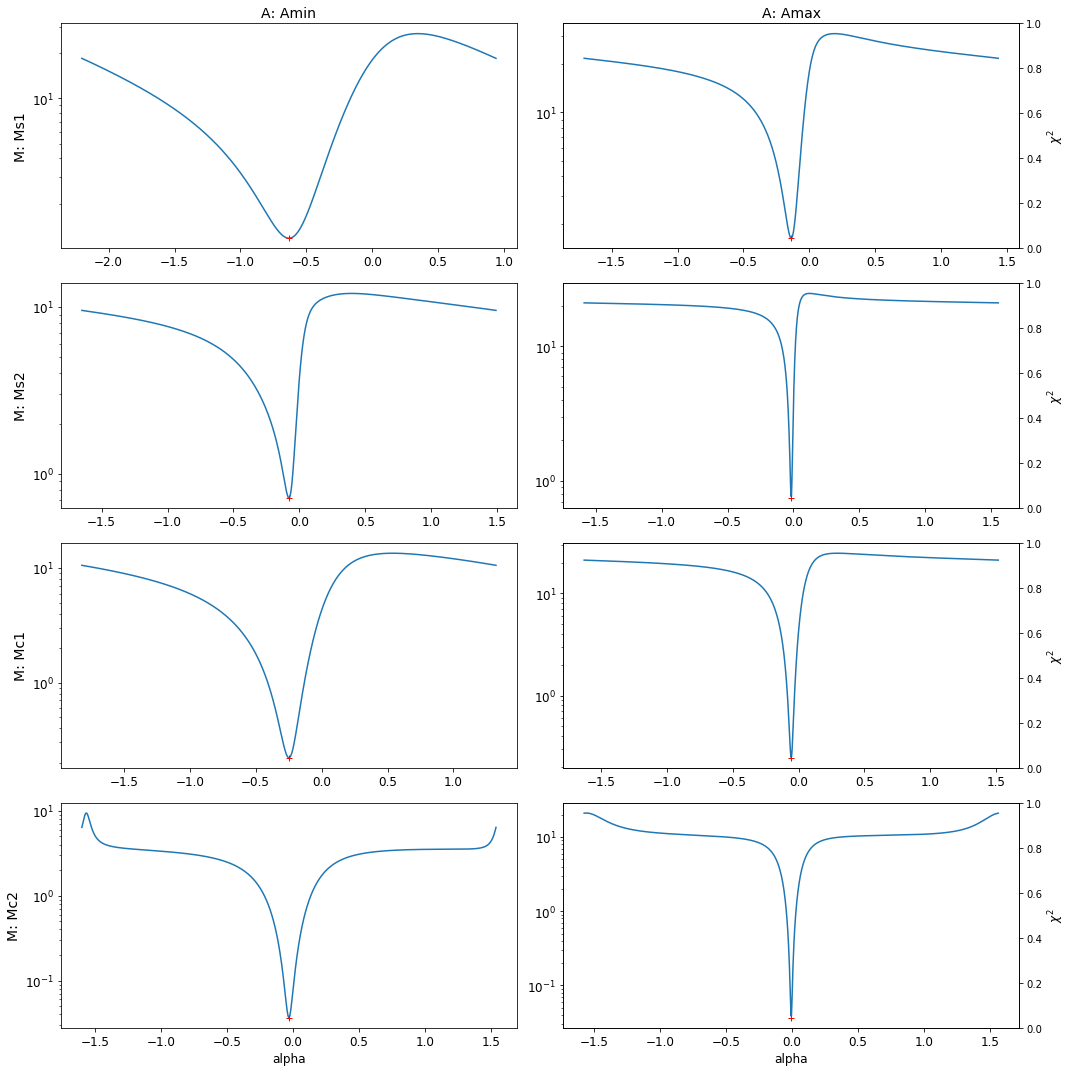

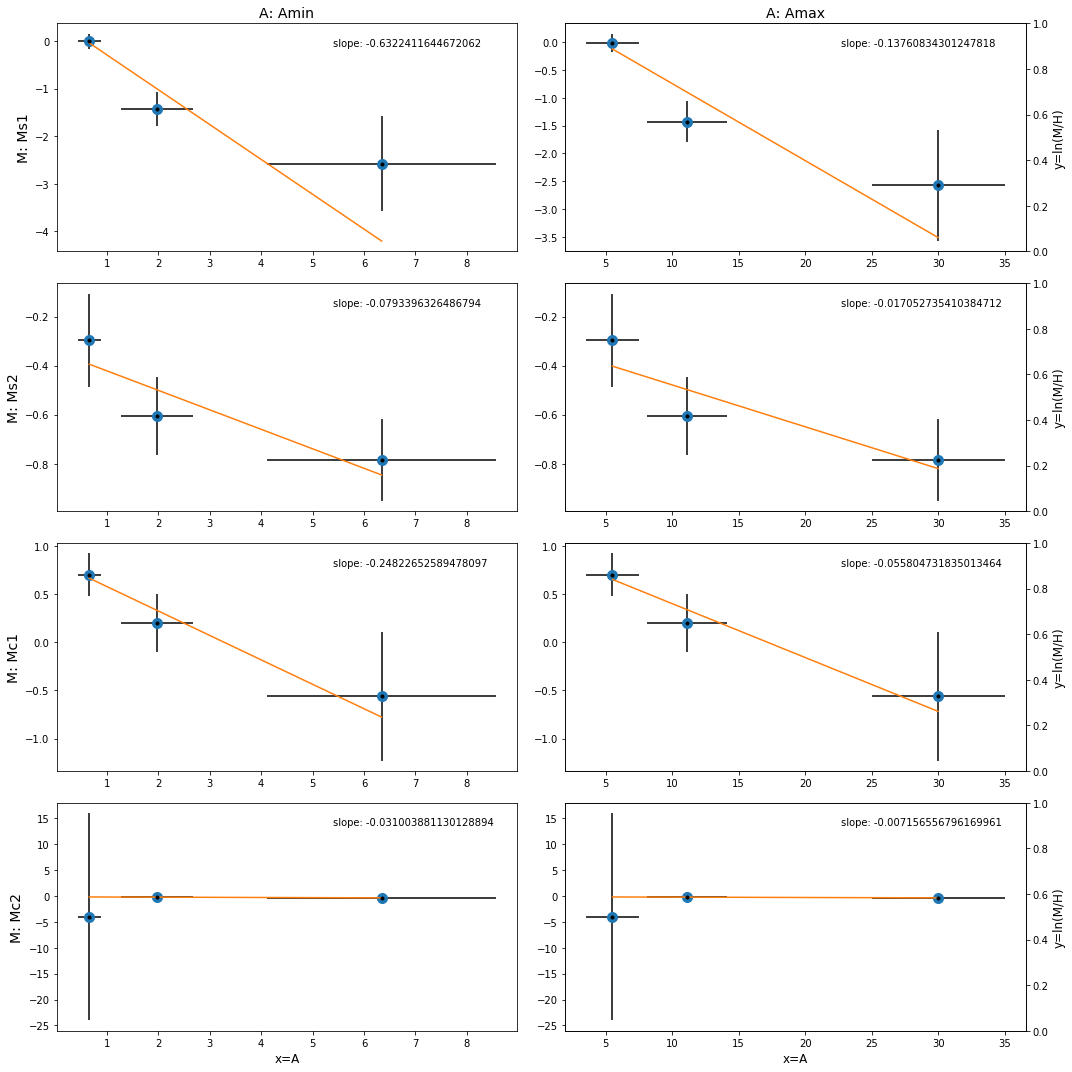

In [307]:
fig1, axes1 = plt.subplots(len(Ms), len(As), figsize=(15,15))
fig2, axes2 = plt.subplots(len(Ms), len(As), figsize=(15,15))

for i, A in enumerate(As):
    for j, M in enumerate(Ms):
        
        ax1 = axes1[j,i]
        ax2 = axes2[j,i]

        # rename
        x = df[A+'-mean']
        y = np.log(df[M+'-mean']/df[H+'-mean'])

        # uncertainties
        ux = df[A+'-std']  # uncertainty in x

        # uncertainty for y, from standard uncertainty propagation
        # https://en.wikipedia.org/wiki/Propagation_of_uncertainty
        dydM = 1/df[M+'-mean']
        stdM = df[M+'-std']
        dydH = -1/df[H+'-mean']
        stdH = df[H+'-std']
        covMH = np.cov(df[M+'-mean'], df[H+'-mean'])[0,1]

        # uncertainty in y (standard deviation)
        # Note that this isn't working if M and H are correlated, which is why the final term is 
        # commented out. Do you expect them to be correlated?
        uy = np.sqrt(dydM**2*stdM**2 + dydH**2*stdH**2)# + 2*dydM*dydH*covMH)
        
        # use polynomial fit for initial guess for straight line
        p0 = np.polyfit(x, y, 1)  # fit a straight line (order is 1)
        alpha0 = np.arctan(p0[1])
        print(alpha0)
        
        # input function to be minimized (chialpha), and the bounds over which to minimize it for alpha
        # https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fminbound.html
        # am using larger bounds here because otherwise Mc1/Amax combination wasn't being properly found
        alphaopt, chiopt, _, _ = fminbound(chialpha, alpha0-np.pi, alpha0+np.pi, args=(x, y, ux, uy), 
                                           xtol=1e-6, full_output=True)
        
        # get optimum p from alphaopt
        alpha = alphaopt
        p, uk2, u2 = calc_p(alpha, x, y, ux, uy)

        # convert to a, b parameters y=a*x + b
        a = np.sin(alpha)/np.cos(alpha)
        b = p/np.cos(alpha)        
        
        # uncertainty calculation: covariance matrix=2*inv(Hessian(chi2))
        n = len(x)
        vk = y*np.cos(alpha) - x*np.sin(alpha) - p
        vka = -y*np.sin(alpha) - x*np.cos(alpha)
        vkaa = -vk - p
        fk = vk*vk
        fka = 2*vk*vka
        fkaa = 2*(vka**2 + vk*vkaa)
        gk = uk2
        gka = 2*np.sin(alpha)*np.cos(alpha)*(ux**2-uy**2)
        gkaa = 2*(ux**2-uy**2)*(np.cos(alpha)**2 - np.sin(alpha)**2)
        Hpp = 2*n/u2
        Halphap = -2*np.sum((vka*gk - gka*vk)/gk**2)
        Halphaalpha = np.sum(fkaa/gk - 2*fka*gka/gk**2 + 2*gka**2*fk/gk**3 - gkaa*fk/gk**2)
        NN = 2/(Hpp*Halphaalpha-Halphap**2)
        var_p = NN*Halphaalpha
        var_alpha = NN*Hpp
        cov_alphap = -NN*Halphap
        Calphap = [var_alpha, var_p, cov_alphap]

        # convert to a & b covariance matrix, following DIN 1319 (4)
        var_a = var_alpha/np.cos(alpha)**4
        var_b = (var_alpha*p*p*np.sin(alpha)**2 + var_p*np.cos(alpha)**2 \
                 + 2*cov_alphap*p*np.sin(alpha)*np.cos(alpha))/np.cos(alpha)**4
        cov_ab = (var_alpha*p*np.sin(alpha) + cov_alphap*np.cos(alpha))/np.cos(alpha)**4
        Cab = [var_a, var_b, cov_ab]
        # ------ end of uncertainty calculation -----------------------------------
        
        # for plotting the fitting algorithm
        num = 1000
        alphatest = np.linspace(alpha-np.pi/2, alpha+np.pi/2, num)
        chitest = [chialpha(alphatest[k], x, y, ux, uy) for k in range(num)]
        ax1.semilogy(alphatest, chitest, alphaopt, chiopt, 'r+')
        ax1.tick_params(labelsize=12)
        if j==0:
            ax1.set_title('A: %s' % A, fontsize=14)
        elif j==len(Ms)-1:
            ax1.set_xlabel('alpha', fontsize=12)
        if i==len(As)-1:
            ax1b = ax1.twinx()
            ax1b.set_ylabel('$\chi^2$', fontsize=12)
        elif i==0:
            ax1.set_ylabel('M: %s' % M, fontsize=14)
        
        # plot trendline for y vs x
        ax2.plot(x, y, 'o', ms=10)
        ax2.plot(x, a*x + b)
        ax2.errorbar(x, y, xerr=ux, yerr=uy, fmt='.k');
        ax2.text(0.6, 0.9, 'slope: ' + str(alphaopt), transform=ax2.transAxes)
        if j==0:
            ax2.set_title('A: %s' % A, fontsize=14)
        elif j==len(Ms)-1:
            ax2.set_xlabel('x=A', fontsize=12)
        if i==len(As)-1:
            ax2b = ax2.twinx()
            ax2b.set_ylabel('y=ln(M/H)', fontsize=12)
        elif i==0:
            ax2.set_ylabel('M: %s' % M, fontsize=14)
        
        print('For A as %s and M as %s: ' % (A, M))
        print('Alpha that minimizes the function: %f' % alphaopt)
        print('Resultant slope and y intercept: %f, %f' % (a, b))
        print('Variance of slope: %f, variance of y intercept: %f, covariance of the two: %f' % (var_a, var_b, cov_ab))
        print('\n')

fig1.tight_layout()
fig2.tight_layout()

fig1.savefig('optimization.png', bbox_inches='tight')
fig1.savefig('optimization.pdf', bbox_inches='tight')
fig2.savefig('slopes.png', bbox_inches='tight')
fig2.savefig('slopes.pdf', bbox_inches='tight')